In [1]:
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as py

In [2]:
FOLDER = './oct_2025_stops'

stops_gdf = gpd.read_file(FOLDER+'/stops.shp')
stops_gdf.to_crs(2958)

,stop_id,stop_code,stop_name,geometry
0,262,662,Danforth Rd at Kennedy Rd,POINT (640096.073 4841618.907)
1,263,929,Davenport Rd at Bedford Rd,POINT (629006.481 4836958.897)
2,264,940,Davenport Rd at Dupont St,POINT (628820.49 4837073.415)
3,265,1871,Davisville Ave at Cleveland St,POINT (630683.404 4840062.438)
4,266,11700,Disco Rd at Attwell Dr,POINT (613221.563 4839663.01)
...,...,...,...,...
9324,25206,16750,55 Nugget Ave,POINT (640138.01 4850278.594)
9325,25207,16753,Culford Rd at Maple Leaf Dr South Side,POINT (621640.237 4840993.992)
9326,25208,16754,1 Front St West - Union Station,POINT (630828.633 4833856.34)
9327,25209,16757,Eglinton Ave West at Russell Rd,POINT (618211.398 4837494.367)


In [3]:
# I was assuming that the route MultiLineStrings were made of segments that begin and end at stops - which would make life easier
# but they do not

# once we can get the stops per route information, the code segments below will work to create a weighted network
# where stops on subway lines have higher weight than streetcars and buses and so on

# route_gdf.plot(column = 'route_type')

# def add_weights(gdf):
#     mapping = {1: 4, 0: 2, 3: 1}

#     gdf.loc['weight'] = 0

#     for index, row in gdf.iterrows():
#         gdf.loc[index,'weight'] = mapping[row['route_type']]
#     return gdf


# t = add_weights(route_gdf)
# print(t['weight'])
# print(route_gdf.head(2))


In [4]:
# # break each route into stops which maintain weights
# from shapely import Point, LineString, MultiLineString

# points = []
# weights = []
# #stop_weight = gpd.GeoDataFrame({'weight': []}, geometry = gpd.GeoSeries(Point()))
# for index, row, in route_gdf.iterrows():
#     segment = route_gdf.loc[index,'geometry']

#     if type(segment) == type(MultiLineString()):
#         for line in segment.geoms:
#             start_p = line.coords[0]
#             points.append(Point(start_p))
#             weights.append(row['weight'])
#     else:
#         start_p = line.coords[0]
#         points.append(Point(start_p))
#         weights.append(row['weight'])

# stops = gpd.GeoDataFrame({'weights': weights, 'geometry': points}, crs = 'EPSG:2958')


In [5]:
try:
    import geoplot
except:
    %pip install geoplot
    import geoplot


<Axes: xlabel='None', ylabel='None'>

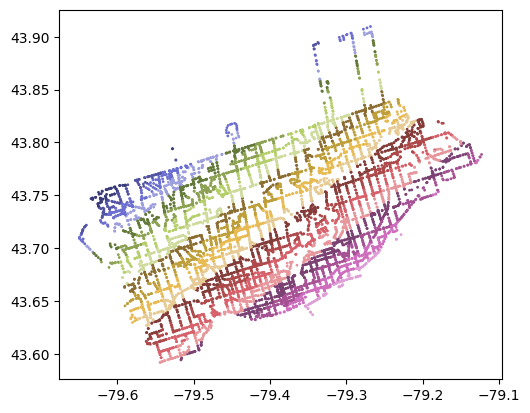

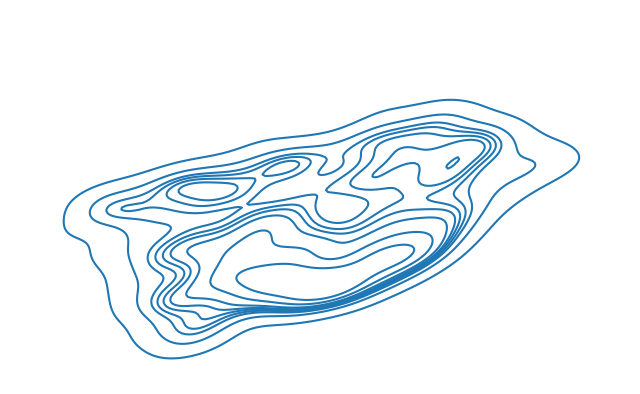

In [6]:
# Playing around with visualizing the stops
stops_gdf['color'] = stops_gdf.geometry.x * stops_gdf.geometry.y
stops_gdf.plot(column = 'color', cmap = 'tab20b', markersize = 1)

# a heatmap type thing would be nice. Geoplot has one option for that - unrefined here
geoplot.kdeplot(stops_gdf)

using the exact code from here:
https://geopandas.org/en/stable/gallery/plotting_with_folium.html 

In [7]:
# folium also supports heat maps
# so we could explore these visualisation options


import folium
from folium import plugins
map = folium.Map(location=[15, 30], tiles="Cartodb dark_matter", zoom_start=10)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in stops_gdf.geometry]
#print(heat_data)

heat_data
plugins.HeatMap(heat_data).add_to(map)
map

# edit this to look nicer
#display(map)
map.save('out.html')


In [8]:
neighbourhood_file = './toronto_neighbourhoods/neighbourhood.shp'
neighbourhood_gdf = gpd.read_file(neighbourhood_file)[['FIELD_3', 'geometry']]
neighbourhood_gdf = neighbourhood_gdf.to_crs('EPSG:2958')



https://gis.stackexchange.com/questions/419702/number-of-points-in-polygon-not-equal-in-qgis-and-geopandas 
used this to help count points

Index(['FIELD_3', 'geometry', 'n_points'], dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>


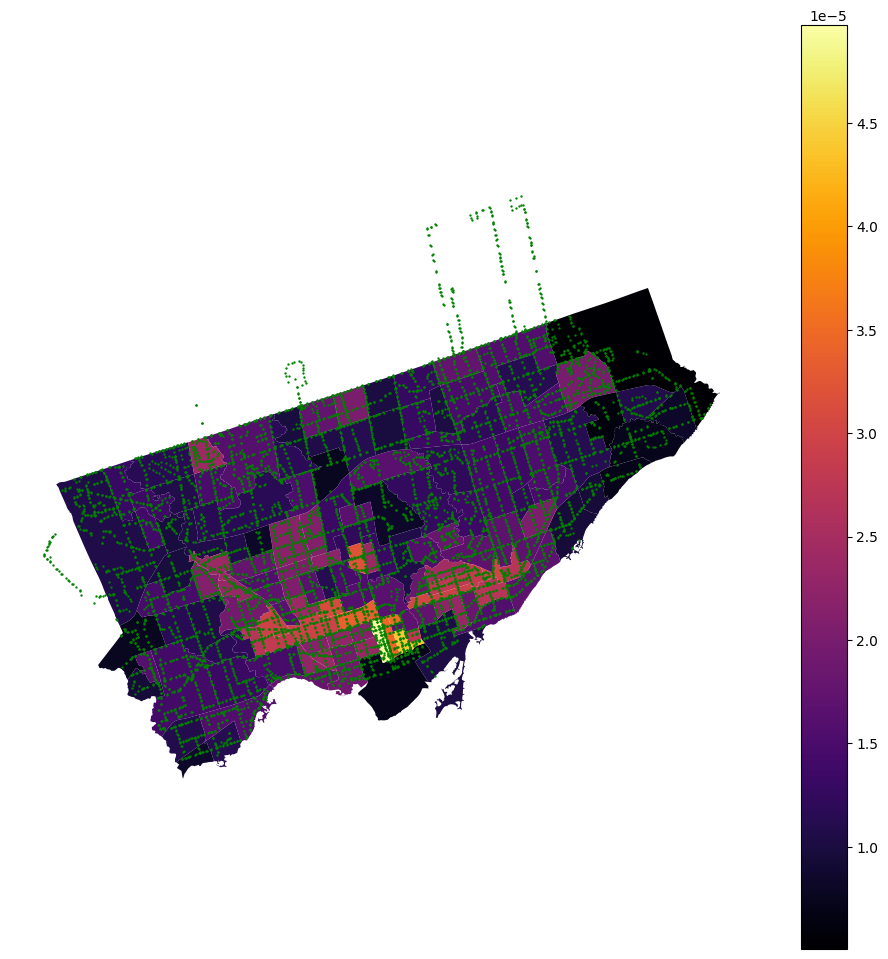

In [10]:
#aggregate stop counts to neighbourhoods
neighbourhood_copy = neighbourhood_gdf.copy()

#from plot_formatter import clean_plot

stops_gdf = stops_gdf.to_crs('EPSG:2958')
neighbourhood_copy.to_crs('EPSG:2958')
fig, ax = py.subplots(1,1, figsize = (12,12))

stops_gdf['point'] = stops_gdf['geometry'].copy()

out = neighbourhood_copy.merge(neighbourhood_copy.sjoin(stops_gdf).groupby('FIELD_3').size().rename('n_points').reset_index())

print(out.columns)
out['point_density'] = out['n_points']/out.area
out.plot(ax=ax, column = 'point_density', cmap ='inferno', legend = True)
stops_gdf.plot(ax =ax, color = 'green', markersize=0.5)
ax.set_axis_off()
#clean_plot(out, 'point_density', 'Point Density of TTC Stops', 'Stops per Square Meter')
#clean_plot(stops_gdf, None, 'none', 'none', 'Greens', ax =ax)
print(type(neighbourhood_copy))